In [2]:
import os
import sys
sys.path.append("../")
from models.unet import UNetDiffusion, UNet_diffusion_normal, UNet_diffusion_sample, UNet_diffusion_mixednormal, UNet_diffusion_mvnormal
from data.datasets import PDE1D
import torch
from models.diffusion import Diffusion, generate_diffusion_samples_low_dimensional, DistributionalDiffusion
import matplotlib.pyplot as plt
import numpy as np
from torch.distributions.lowrank_multivariate_normal import LowRankMultivariateNormal


device = "cuda"
torch.set_grad_enabled(False)

In [3]:
test_dataset = PDE1D(
    data_dir="../data/",
    pde="Burgers",
    var="test",
    downscaling_factor=4,
    normalize=True,
    last_t_steps=2,
    temporal_downscaling_factor=2,
    select_timesteps="random"
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=3,
    shuffle=True,
    num_workers=0,
)

target_dim, input_dim = (
    (1, *test_dataset.get_dimensions()),
    (3, *test_dataset.get_dimensions()),
)
grid = test_dataset.get_coordinates()[0]

In [4]:
cfg_scale = 0
x_T_sampling_method="standard"
n_timesteps = 50
n_samples = 25
t_steps = 50
ddim_churn = 1.0
noise_schedule = "linear"

In [5]:
def plot_predictions(input, target, pred, grid, last_t_timesteps = 2):
    fig, axs = plt.subplots(3, 3, figsize=(18, 8))

    input_last_t = input[:,last_t_timesteps-1].cpu()
    mean_prediction = pred[:,0].mean(axis = -1).cpu()
    pred = pred.cpu()
    target = target.cpu()
    for i in range(3):
        axs[i,0].plot(grid, input_last_t[i].numpy())

        for j in range(n_samples):
            axs[i,1].plot(grid, (pred[i,0,:,j]+input_last_t[i]).numpy(), alpha=0.2, color="grey")
        axs[i,1].plot(grid, (target[i,0]+input_last_t[i]).numpy())
        axs[i,1].plot(grid, (mean_prediction[i]+input_last_t[i]).numpy(), label="Mean prediction", linestyle = "dashed")
        axs[i,1].set_ylim([(mean_prediction[i]+input_last_t[i]).min()-0.2, (mean_prediction[i]+input_last_t[i]).max()+0.2])


        for j in range(n_samples):
            axs[i,2].plot(grid, pred[i,0,:,j].numpy(), alpha=0.2, color="grey")
        axs[i,2].plot(grid, target[i,0].numpy(), label = "Truth")
        axs[i,2].plot(grid, mean_prediction[i].numpy(), label="Mean prediction", linestyle = "dashed")
        #axs[i,2].set_ylim([mean_prediction[i].min()-0.2, mean_prediction[i].max()+0.2])

        axs[i,2].legend()


    axs[0,2].set_title("Residual prediction")
    axs[0,1].set_title("Original scale prediction")
    axs[0,0].set_title("Input")

In [6]:
# Batch to analyze
b = 0

In [7]:
target, input = next(iter(test_loader))
# Repeat across time axis
input = input.to(device)
target = target.to(device)

# Normal

In [8]:
ckpt_path = "../results/Burgers_normal/Datetime_20250728_090415_Loss_1D_Burgers_UNet_diffusion_.pt"
distributional_method = "normal"

In [9]:
backbone =  UNetDiffusion(
            d=1,
            conditioning_dim=3,
            hidden_channels=64,
            in_channels=1,
            out_channels=1,
            init_features=64,
            domain_dim = target_dim[-1]
        )

model = UNet_diffusion_normal(
    backbone=backbone,
    d=1,
    target_dim = 1,
)
model.load_state_dict(
    torch.load(ckpt_path, map_location=device)
)
model = model.to(device)


/tmp/ipykernel_405619/3274195715.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(ckpt_path, map_location=device)


In [10]:
diffusion = DistributionalDiffusion(
    noise_steps=n_timesteps,
    img_size=target_dim,
    device=device,
    ddim_churn=ddim_churn,
    distributional_method=distributional_method,
    x_T_sampling_method=x_T_sampling_method,
    noise_schedule=noise_schedule
)

n = input.shape[0]
pred = None
conditioning = input

In [11]:
timestep_array = torch.zeros(n_timesteps -1, *target.shape)

In [12]:
x = diffusion.sample_x_T((n, *diffusion.img_size), pred, inference=True)
for step, i in enumerate(reversed(range(1, diffusion.noise_steps))):                
    t = (torch.ones(n) * i).long().to(diffusion.device)
    predicted_noise = diffusion.sample_noise(model, x, t, conditioning, pred)
    # Generate prediction
    mu_sigma_pred = model(x, t, conditioning, pred = pred)
    _, sigma = torch.split(mu_sigma_pred, 1, -1)
    timestep_array[step] = sigma.squeeze(-1)

    x = diffusion.sample_x_t_inference_DDIM(x, t, predicted_noise, pred, i)

In [13]:
normal_cov = torch.diag_embed(timestep_array.squeeze(2), dim1 = -1, dim2 = -2).cpu()

# Multivariate normal

In [14]:
ckpt_path = "../results/20250728_202948_debug/Datetime_20250729_055313_Loss_1D_Burgers_UNet_diffusion_.pt"
distributional_method = "mvnormal"

In [15]:
backbone =  UNetDiffusion(
            d=1,
            conditioning_dim=3,
            hidden_channels=64,
            in_channels=1,
            out_channels=1,
            init_features=64,
            domain_dim = target_dim[-1]
        )


model = UNet_diffusion_mvnormal(
    backbone=backbone,
    d=1,
    target_dim = 1,
    domain_dim = target_dim[1:],
    rank = 10,
    method = "lora"
)

dict = torch.load(ckpt_path, map_location=device)
model.load_state_dict(dict
    
)
model = model.to(device)


/tmp/ipykernel_405619/1918578053.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dict = torch.load(ckpt_path, map_location=device)


In [16]:
diffusion = DistributionalDiffusion(
    noise_steps=n_timesteps,
    img_size=target_dim,
    device=device,
    ddim_churn=ddim_churn,
    distributional_method=distributional_method,
    x_T_sampling_method=x_T_sampling_method,
    noise_schedule=noise_schedule
)

n = input.shape[0]
pred = None
conditioning = input

In [17]:
timestep_array = torch.zeros(n_timesteps -1, *target.shape, target.shape[-1]).squeeze()
timestep_array.shape

torch.Size([49, 3, 256, 256])

In [18]:
x = diffusion.sample_x_T((n, *diffusion.img_size), pred, inference=True)
for step, i in enumerate(reversed(range(1, diffusion.noise_steps))):                
    t = (torch.ones(n) * i).long().to(diffusion.device)
    predicted_noise = diffusion.sample_noise(model, x, t, conditioning, pred)
    # Generate prediction
    mu_sigma_pred = model(x, t, conditioning, pred = pred)
    mu = mu_sigma_pred[...,0]
    diag = mu_sigma_pred[...,1]
    lora = mu_sigma_pred[...,2:]
    mvnorm = LowRankMultivariateNormal(mu, lora, diag)
    timestep_array[step] = mvnorm.covariance_matrix.squeeze(1)

    x = diffusion.sample_x_t_inference_DDIM(x, t, predicted_noise, pred, i)

In [19]:
mvnormal_cov = timestep_array

# Sample

In [20]:
def batched_cov_vectorized(x: torch.Tensor) -> torch.Tensor:
    """
    Vectorized batched covariance computation.
    Args:
        x (torch.Tensor): (B, C, N)
    Returns:
        torch.Tensor: (B, C, C)
    """
    B, C, N = x.shape
    mean = x.mean(dim=-1, keepdim=True)  # (B, C, 1)
    x_centered = x - mean                # (B, C, N)
    cov = x_centered @ x_centered.transpose(-1, -2) / (N - 1)  # (B, C, C)
    return cov

In [21]:
ckpt_path = "../results/Burgers_sample/Datetime_20250728_114053_Loss_1D_Burgers_UNet_diffusion_.pt"
distributional_method = "sample"

In [22]:
backbone =  UNetDiffusion(
            d=1,
            conditioning_dim=4,
            hidden_channels=64,
            in_channels=1,
            out_channels=1,
            init_features=64,
            domain_dim = target_dim[-1]
        )

model = UNet_diffusion_sample(
    backbone=backbone,
    d=1,
    target_dim = 1,
    hidden_dim=64
)

dict = torch.load(ckpt_path, map_location=device)
model.load_state_dict(dict
    
)
model = model.to(device)


/tmp/ipykernel_405619/3668535196.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dict = torch.load(ckpt_path, map_location=device)


In [23]:
diffusion = DistributionalDiffusion(
    noise_steps=n_timesteps,
    img_size=target_dim,
    device=device,
    ddim_churn=ddim_churn,
    distributional_method=distributional_method,
    x_T_sampling_method=x_T_sampling_method,
    noise_schedule=noise_schedule
)

n = input.shape[0]
pred = None
conditioning = input

In [24]:
timestep_array = torch.zeros(n_timesteps -1, *target.shape, target.shape[-1]).squeeze()

In [25]:
x = diffusion.sample_x_T((n, *diffusion.img_size), pred, inference=True)
for step, i in enumerate(reversed(range(1, diffusion.noise_steps))):                
    t = (torch.ones(n) * i).long().to(diffusion.device)
    predicted_noise = diffusion.sample_noise(model, x, t, conditioning, pred)
    # Generate prediction
    predictions = model(x, t, conditioning, pred = pred, n_samples=100)
    timestep_array[step] = batched_cov_vectorized(predictions.squeeze(1))

    x = diffusion.sample_x_t_inference_DDIM(x, t, predicted_noise, pred, i)

In [26]:
sample_cov = timestep_array

# Plots

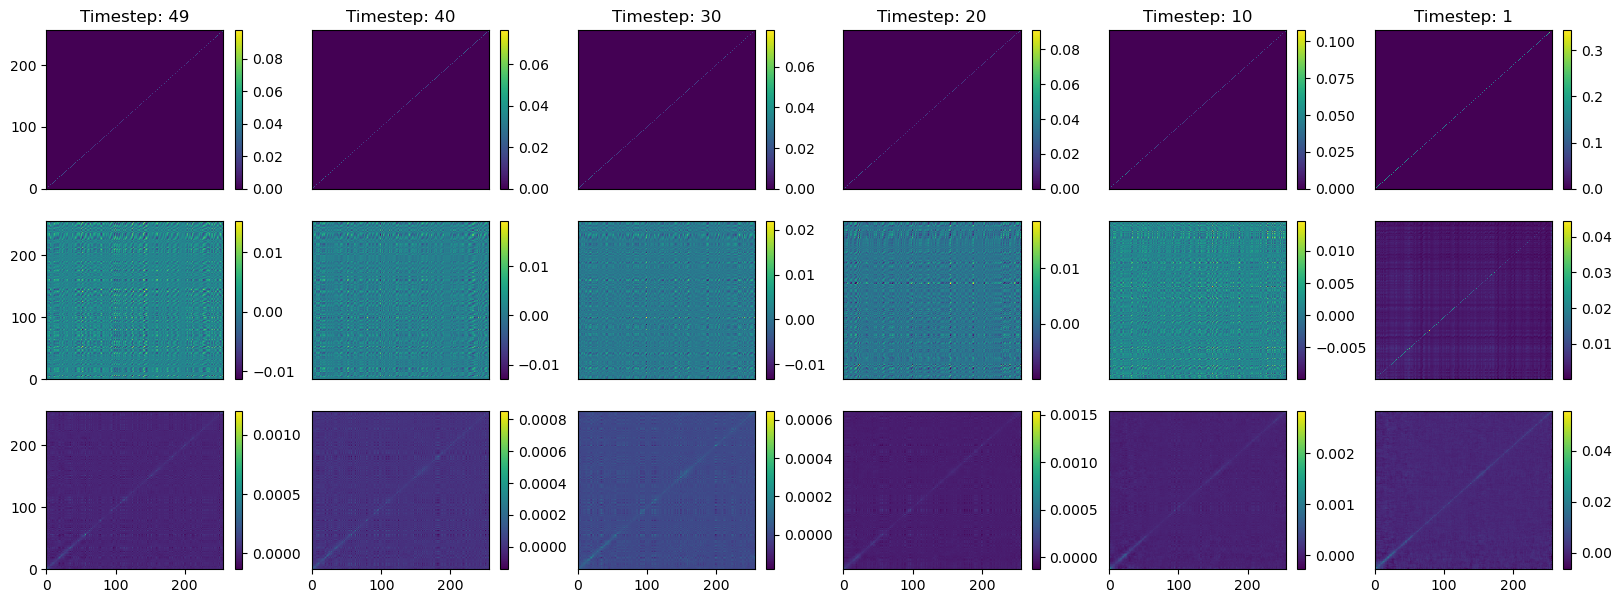

In [27]:
steps = [1, 10, 20, 30, 40, 49]
n_rows = 3

fig, axs = plt.subplots(n_rows, len(steps), figsize = (20,7))

for i,step in enumerate(steps):
    im1 = axs[0,i].pcolormesh(np.log(normal_cov[step-1,b]+1))
    plt.colorbar(im1)
    axs[0,i].set_title(f"Timestep: {n_timesteps-(step)}")

    im2 = axs[1,i].pcolormesh(np.log(mvnormal_cov[step-1, b]+1))
    plt.colorbar(im2)

    im3 = axs[2,i].pcolormesh(np.log(sample_cov[step-1, b]+1))
    plt.colorbar(im3)

for i in range(n_rows-1):
    for j in range(len(steps)):
        axs[i,j].set_xticks([])

for i in range(1,len(steps)):
    for j in range(n_rows):
        axs[j,i].set_yticks([])

# Sample

In [28]:
ckpt_path = "../results/Burgers_sample/Datetime_20250728_114053_Loss_1D_Burgers_UNet_diffusion_.pt"
distributional_method = "sample"

In [29]:
backbone =  UNetDiffusion(
            d=1,
            conditioning_dim=4,
            hidden_channels=64,
            in_channels=1,
            out_channels=1,
            init_features=64,
            domain_dim = target_dim[-1]
        )


model = UNet_diffusion_sample(
    backbone=backbone,
    d=1,
    target_dim = 1,
    hidden_dim=64
)



dict = torch.load(ckpt_path, map_location=device)
model.load_state_dict(dict
    
)
model = model.to(device)


/tmp/ipykernel_405619/2306179049.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dict = torch.load(ckpt_path, map_location=device)


In [30]:
diffusion = DistributionalDiffusion(
    noise_steps=n_timesteps,
    img_size=target_dim,
    device=device,
    ddim_churn=ddim_churn,
    distributional_method=distributional_method,
    x_T_sampling_method=x_T_sampling_method,
    noise_schedule=noise_schedule
)

n = input.shape[0]
pred = None
conditioning = input

In [31]:
pred = generate_diffusion_samples_low_dimensional(
    model=model,
    input = input,
    n_timesteps=50,
    target_shape=target.shape,
    n_samples=n_samples,
    distributional_method=distributional_method,
    x_T_sampling_method=x_T_sampling_method,
    cfg_scale=cfg_scale,
    noise_schedule="linear",
)

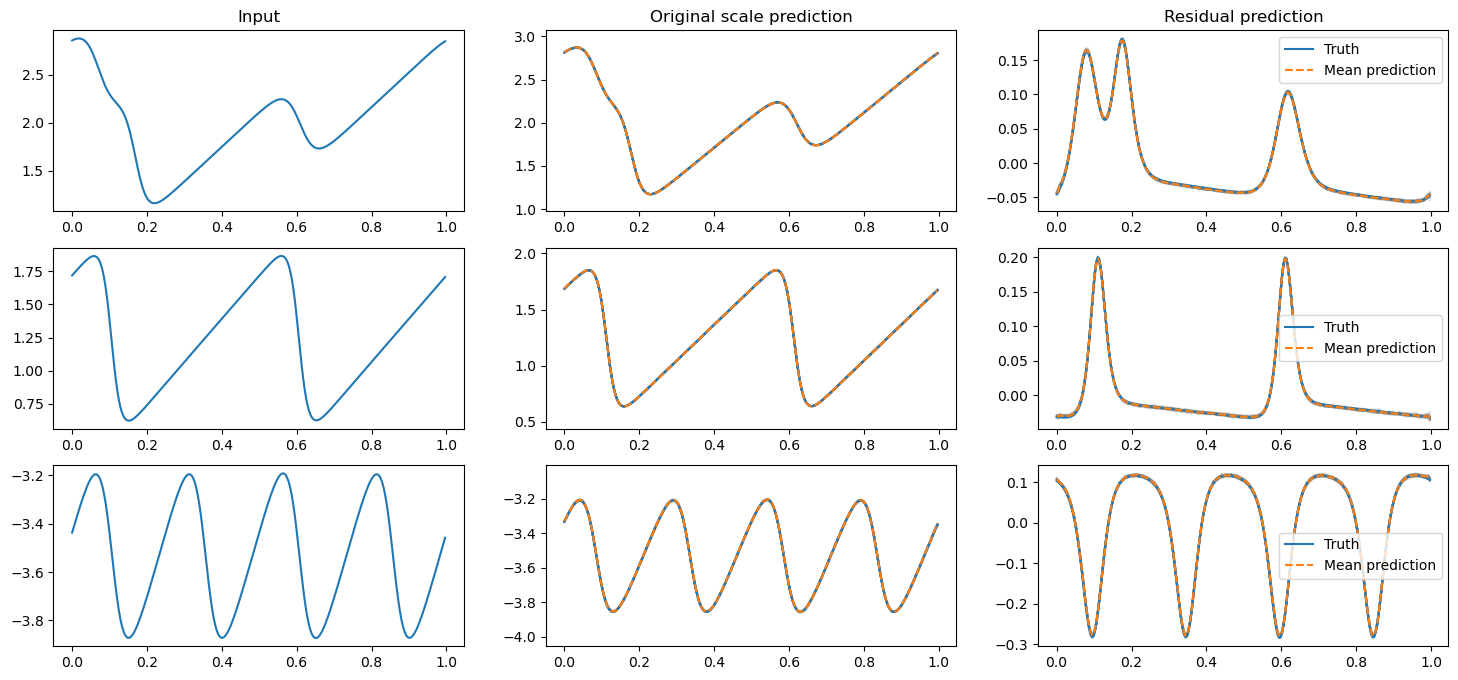

In [32]:
plot_predictions(input, target, pred, grid)

In [33]:

grid_input = input[:,2:3,:]
t0 = input[:,1:2,:]
full_array = torch.zeros(input.shape[0], 1, input.shape[2], t_steps,n_samples, device=device)

for i in range(n_samples):
    autoregressive_input = input.clone()
    pred_array = torch.zeros(input.shape[0], 1, input.shape[2], t_steps, device=device)
    for t in range(t_steps):
        pred = generate_diffusion_samples_low_dimensional(
            model=model,
            input = autoregressive_input,
            n_timesteps=n_timesteps,
            target_shape=target.shape,
            n_samples=1,
            distributional_method=distributional_method,
            x_T_sampling_method=x_T_sampling_method,
            cfg_scale=cfg_scale,
            noise_schedule="linear",
        )
        if t == 0:
            pred_array[...,t] = pred.squeeze(-1)+ t0
        else:
            pred_array[...,t] = pred.squeeze(-1) + pred_array[...,t-1]

        if t == 1:
            autoregressive_input = torch.cat([t0, pred_array[...,0], grid_input], dim = 1)
        elif t > 1:
            autoregressive_input = torch.cat([pred_array[...,t-1],pred_array[...,t], grid_input], dim = 1)
    # Save
    full_array[...,i] = pred_array

NameError: name 'trajectory' is not defined

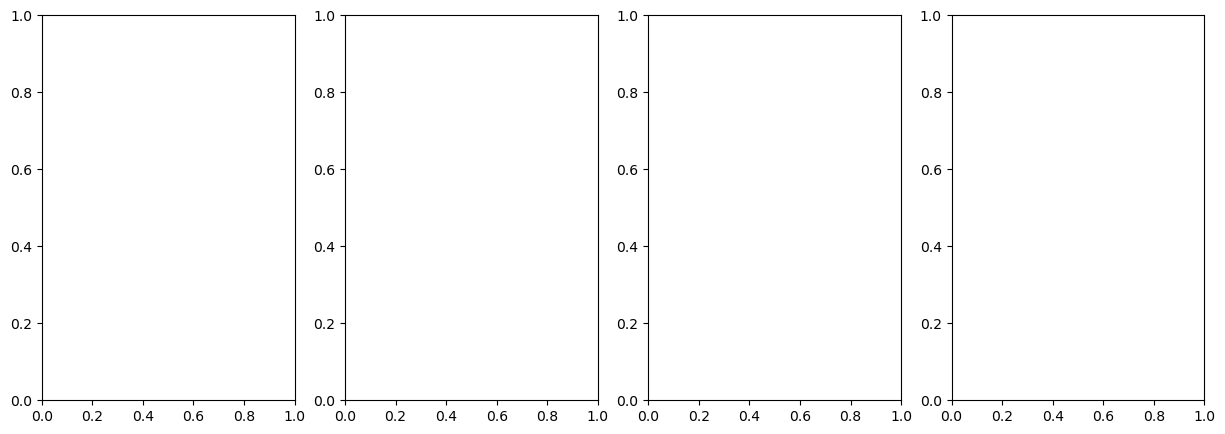

In [34]:
fig, axs = plt.subplots(1, 4, figsize = (15,5))

im1 = axs[0].pcolormesh(trajectory[b,0,2:].cpu())
axs[0].set_title("Truth")
cb1 = fig.colorbar(im1, ax = axs[0])

im2 = axs[1].pcolormesh(full_array[b,0,...,0].t().cpu())
axs[1].set_title("Trajectory sample")
cb1 = fig.colorbar(im2, ax = axs[1])

im3 = axs[2].pcolormesh(full_array[b,0].mean(axis = -1).t().cpu())
axs[2].set_title("Mean trajectory")
cb1 = fig.colorbar(im3, ax = axs[2])

im4 = axs[3].pcolormesh(full_array[b,0].std(axis = -1).t().cpu())
axs[3].set_title("Std trajectory")
cb1 = fig.colorbar(im4, ax = axs[3])

# Multivariate normal

In [ ]:
ckpt_path = "../results/20250728_202948_debug/Datetime_20250729_055313_Loss_1D_Burgers_UNet_diffusion_.pt"
distributional_method = "mvnormal"

In [ ]:
backbone =  UNetDiffusion(
            d=1,
            conditioning_dim=3,
            hidden_channels=64,
            in_channels=1,
            out_channels=1,
            init_features=64,
            domain_dim = target_dim[-1]
        )

#backbone.conditioning_projection = torch.nn.Identity()

model = UNet_diffusion_mvnormal(
    backbone=backbone,
    d=1,
    target_dim = 1,
    domain_dim = target_dim[1:],
    rank = 10,
    method = "lora"
)

dict = torch.load(ckpt_path, map_location=device)
model.load_state_dict(dict
    
)
model = model.to(device)


/tmp/ipykernel_385645/732789396.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dict = torch.load(ckpt_path, map_location=device)


In [ ]:
pred = generate_diffusion_samples_low_dimensional(
    model=model,
    input = input,
    n_timesteps=50,
    target_shape=target.shape,
    n_samples=n_samples,
    distributional_method=distributional_method,
    x_T_sampling_method=x_T_sampling_method,
    cfg_scale=cfg_scale,
    noise_schedule="linear",
)

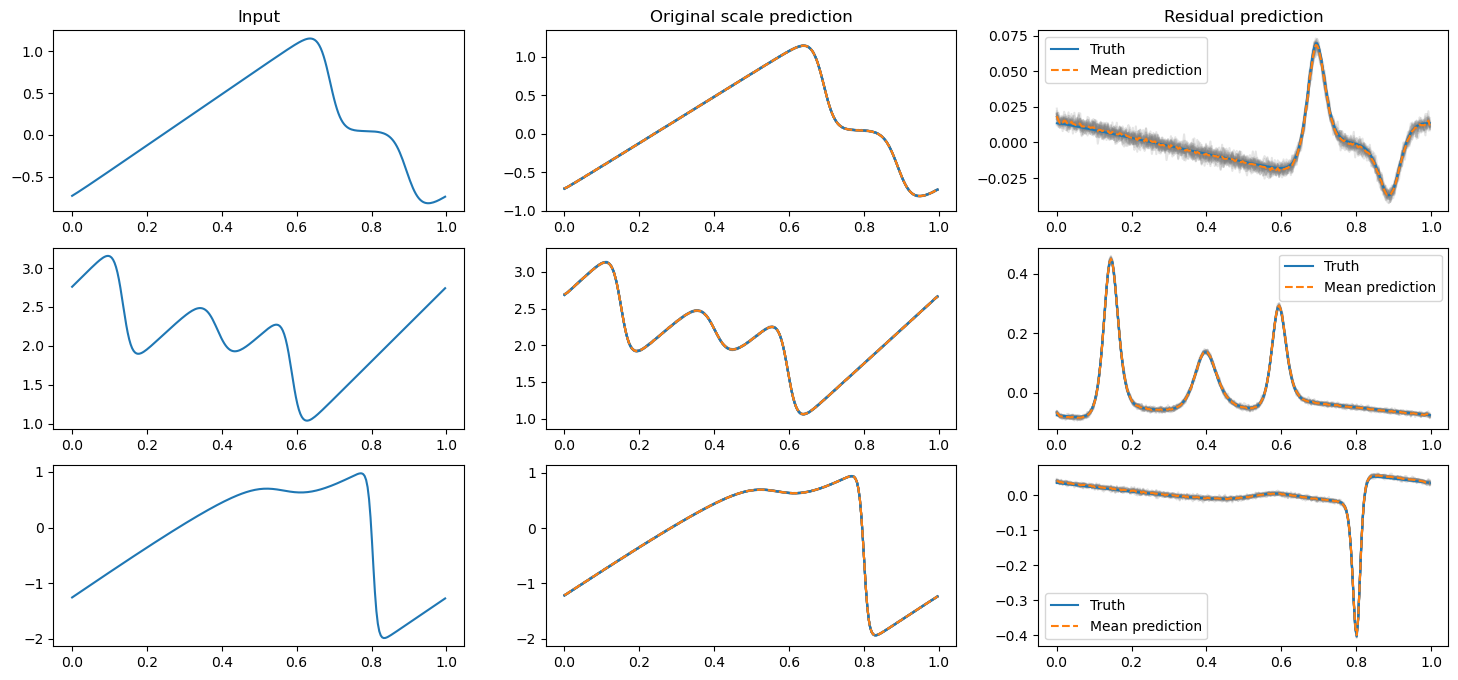

In [ ]:
plot_predictions(input, target, pred, grid)

In [ ]:
grid_input = input[:,2:3,:]
t0 = input[:,1:2,:]
full_array = torch.zeros(input.shape[0], 1, input.shape[2], t_steps,n_samples, device=device)

for i in range(n_samples):
    autoregressive_input = input.clone()
    pred_array = torch.zeros(input.shape[0], 1, input.shape[2], t_steps, device=device)
    for t in range(t_steps):
        pred = generate_diffusion_samples_low_dimensional(
            model=model,
            input = autoregressive_input,
            n_timesteps=n_timesteps,
            target_shape=target.shape,
            n_samples=1,
            distributional_method=distributional_method,
            x_T_sampling_method=x_T_sampling_method,
            cfg_scale=cfg_scale,
            noise_schedule="linear",
        )
        if t == 0:
            pred_array[...,t] = pred.squeeze(-1)+ t0
        else:
            pred_array[...,t] = pred.squeeze(-1) + pred_array[...,t-1]

        if t == 1:
            autoregressive_input = torch.cat([t0, pred_array[...,0], grid_input], dim = 1)
        elif t > 1:
            autoregressive_input = torch.cat([pred_array[...,t-1],pred_array[...,t], grid_input], dim = 1)
    # Save
    full_array[...,i] = pred_array

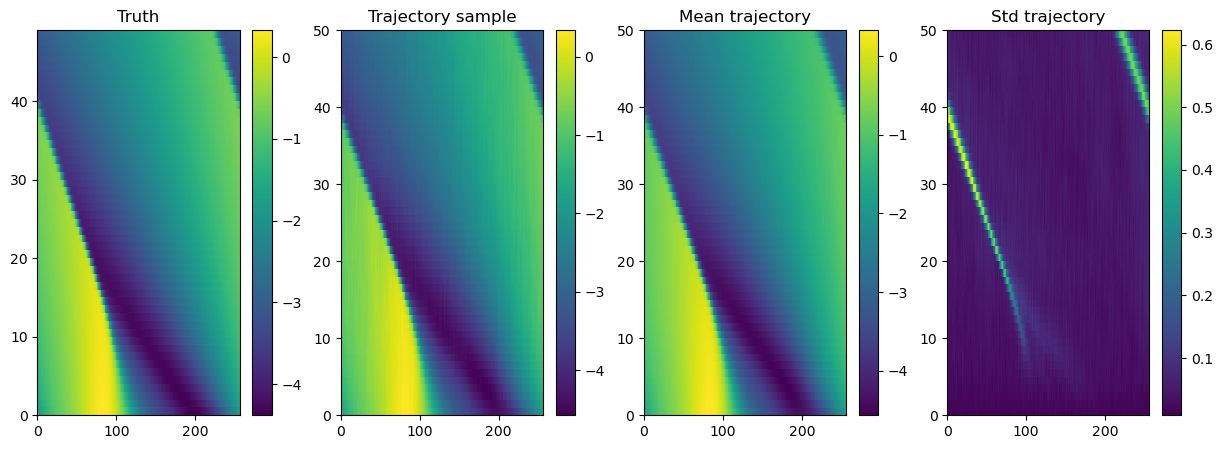

In [ ]:
fig, axs = plt.subplots(1, 4, figsize = (15,5))

im1 = axs[0].pcolormesh(trajectory[b,0,2:].cpu())
axs[0].set_title("Truth")
cb1 = fig.colorbar(im1, ax = axs[0])

im2 = axs[1].pcolormesh(full_array[b,0,...,0].t().cpu())
axs[1].set_title("Trajectory sample")
cb1 = fig.colorbar(im2, ax = axs[1])

im3 = axs[2].pcolormesh(full_array[b,0].mean(axis = -1).t().cpu())
axs[2].set_title("Mean trajectory")
cb1 = fig.colorbar(im3, ax = axs[2])

im4 = axs[3].pcolormesh(full_array[b,0].std(axis = -1).t().cpu())
axs[3].set_title("Std trajectory")
cb1 = fig.colorbar(im4, ax = axs[3])

: 

: 

: 

: 